# Drawbacks of this Homemade Simulator (and what could have been Done Better?)

It is usually not customary to start a project with its drawbacks but I believe it is essential to know the drawbacks of a piece of code or application before using it.

#### Swap Gates

1. No functionality for Swap gates. 

    **(Solution)** This could not be completed due to time constraints. Can be implemented. Need to apply CNOT gates consecutively while switching the target and control qubits.

#### Variational Algorithms
2. No functionality to run a variational algorithm using the parametric circuit. 

    **(Solution)** The parametric circuit is working in the code. To run such an algorithm, we can create a normalized random gate matrix and initialize the paramteric circuit. We can then call the parametric circuit, compute the distance between the random state and the parametric gate output (with the initial states), which becomes our cost. Next, we update the parameters of the paramteric circuit such that the distance (our cost) reduces. Once we reach a minimum, we then have the gate representation of the random circuit. 
   
#### Code is slow after 12 qubits
3. The code is able to simulate 12 qubits seamlessly. The moment we get to 12 qubits, it's visible that the code takes a lot of time to run. Qiskit on the other hand can seamlessly even run 20 qubit circuits (Wow!).

    **(Solution)** One potential solution that I can think of is to implement the kronecker products in FORTRAN as a subroutine. We can easily use an import such as F2PY (https://numpy.org/doc/stable/f2py/) to speed up the calculations. Did not test it but should be easily doable given that writing FORTRAN sub-routines are pretty straightforward. 
    

## Future Plans

Deal with each of the above issues and mark them solved eventually. Had an amazing time buidling this (okayish) simulator. Could have done better. But it's the best I could do, ***for now***.

---



To construct the simulator, we only make use of Numpy. For plotting, we import Matplotlib. Not necessary to import Matplolib but the visulaization makes the results a bit more intuituve. 

In [184]:
import numpy as np 
import matplotlib.pyplot as plt

# **Single Qubit Gates**

Single qubit gates are 2 $\times$ 2 matrices. Some of the gates we implement in this (simple) simulator are the following: 

**Identity Gate**

The matrix is given as, 

\begin{equation*}
I = 
\begin{bmatrix}
1 & 0\\
0 & 1
\end{bmatrix}
\end{equation*}

**Pauli-X Gate (Quantum NOT)**

This gate is the quantum equivalent of the classical NOT gate. In the z-direction basis, the state $|0\rangle$ and $|1 \rangle$ are mapped to the states $|1\rangle$ and $|0 \rangle$ respectively. The X-gate is represented by the $\sigma_x$ matrix, which is given as,

\begin{equation*}
X=\sigma_x=
\begin{bmatrix}
0 & 1\\
1 & 0
\end{bmatrix}
\end{equation*}

Therefore, if we take this matrix and apply it on a general qubit state which is represented as $|\psi \rangle = \alpha |0 \rangle + \beta |1 \rangle$, the state becomes $|\psi' \rangle = \alpha |1 \rangle + \beta |0 \rangle$. This gate can also be thought of as rotating a qubit around the X-axis by $\pi$ on the Bloch sphere.

**Pauli-Y Gate**

Just as the X-gate represents a rotation of a qubit by an angle $\pi$ around the X-axis, the Y-gate does the same around the Y-axis. The Y-gate or the $\sigma_y$ matrix is given as, 

\begin{equation*}
Y=\sigma_y=
\begin{bmatrix}
0 & -i\\
i & 0
\end{bmatrix}
\end{equation*}

**Pauli-Z Gate (Phase Shift Gate)**

The Z-gate rotates a qubit by $\pi$ in the Z-direction. This gate is also called the phase shift gate because it flips $|1 \rangle$ to $-|1 \rangle$, while leaving the $|0 \rangle$ state unchanged. In other words, $Z|\psi \rangle = Z(\alpha |0 \rangle + \beta |1 \rangle)$ would give us $|\psi' \rangle = \alpha |0 \rangle - \beta |1 \rangle$. 

\begin{equation*}
Z=\sigma_z=
\begin{bmatrix}
1 & 0\\
0 & -1
\end{bmatrix}
\end{equation*}


**Hadamard Gate ($\sqrt{NOT}$ Gate)**

This is one of the most widely used gates in quantum computing. The H-gate matrix is given as, 

\begin{equation*}
H = \frac{1}{\sqrt 2}
\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix}
\end{equation*}

The H gate when it acts on $|0 \rangle$, we get, 

\begin{equation*}
H |0\rangle = \frac{1}{\sqrt 2}
\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix}
\begin{bmatrix}
1 \\ 0
\end{bmatrix}
=
\frac{|0 \rangle + |1 \rangle }{\sqrt 2}
=
|+\rangle
\end{equation*}

Similarly, when the H gate acts on $|1 \rangle$, we get,

\begin{equation*}
H |1\rangle = \frac{1}{\sqrt 2}
\begin{bmatrix}
1 & 1\\
1 & -1
\end{bmatrix}
\begin{bmatrix}
0 \\ 1
\end{bmatrix}
=
\frac{|0 \rangle - |1 \rangle }{\sqrt 2}
=|-\rangle
\end{equation*}

The reason we call it a $\sqrt{NOT}$ is because it evolves the $|0 \rangle$ and $|1 \rangle$ halfway in between them on either sides of those states. Algebraically, the square of the NOT gate is *not* the H gate.


# **Multi-Qubit Gates**

**CNOT Gate**

In the CNOT gate, there is a control qubit and a target qubit. The CNOT gate is very similar to the classical XOR gate. In CNOT gate, if the control qubit is $|0 \rangle$, then the control qubit remains unchanged. In the case that the control qubit is $|1 \rangle$, the target is inverted or an X gate is applied to it. We can represent this gate using the following matrix, 

\begin{equation*}
CNOT = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 1 & 0\\
\end{bmatrix}
\end{equation*}

When we have consecutive qubits, using the above matrix is very easy as its application is similar to the single qubit gates. In the case that we want to apply it to non-consecutive qubits, formulating the matrix can become tedious. To solve this problem, we make use of the projection operators. Let's define the two projection operators we will use, $P_0 = |0 \rangle \langle 0|$ and $P_1 = |1 \rangle \langle 1|$. This will help us define a quantum-if statement. Let's see how we can define the CNOT gate using projection operators, starting from a simple example and then a more complicated example. 

If we have a two-qubit state and we want to make the first qubit the control gate and the second the target qubit, we can write the gate as, 

$P_0 \bigotimes I$ + $P_1 \bigotimes X$

which says, if the first qubit is $|0 \rangle$ ($P_0$ will tell you if it is or not), do nothing to the second qubit (apply identity gate). The second term says, if the first qubit is $|1 \rangle$ ($P_1$ will tell you if it is or not), apply an X-gate to the second qubit.

If we are able to grasp this concept, we can extend the CNOT operation to any number of qubits and to any position we like. Let's try an example with a six qubit state, where the 2$^{nd}$ qubit is control and 5$^{th}$ is the target qubit. Let's write the operation for that, 

$I \bigotimes P_0 \bigotimes I \bigotimes I \bigotimes I \bigotimes I$ + $I \bigotimes P_1 \bigotimes I \bigotimes I \bigotimes X \bigotimes I$

This is how we can apply the CNOT gate to any arbitrary qubit state.


**Swap Gate**

The Swap gate swaps the qubit state and the matrix is represented as, 

\begin{equation*}
SWAP = 
\begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 0 & 1 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 0 & 1\\
\end{bmatrix}
\end{equation*}

This operation is equivalent to applying three CNOT gates while switching the control and target qubits. More reference can be found here (https://qiskit.org/textbook/ch-gates/more-circuit-identities.html#swapping). 

We first construct a class of the gates we intend to call in our simulator. This class is customizable and can be expanded to include more unitary gates. Creating a class helps us keep the code more organized. 

In [185]:
class gates():
    
    def __init__(self):
        pass                                      # Do nothing
    
    def identity(self,size):
        return(np.eye(size))                      # Identity gate
    
    def x(self,dummy):
        x=np.array([[0,1],[1,0]])                 # X-gate
        return (x)
    
    def y(self,dummy):
        y=np.array([[0,-1.0j],[1.0j,0]])          # Y-gate
        return (y)
    
    def z(self,dummy):
        z=np.array([[1,0],[0,-1]])                # Z-gate
        return (z)
    
    def h(self,dummy):
        h=np.sqrt(1/2)*np.array([[1,1],[1,-1]])   # H-gate
        return (h)
    
    def s(self,dummy):
        s=np.array([[1,0],[0,1.0j]])              # S-gate
        return (s)

    def t(self,dummy):
        t=np.array([[1,0],[0,np.exp(1.0j*np.pi/4)]]) # T-gate
        return (t)
    
    def U3(self,params):
        # The params come in as theta, phi, and lambda.            
        # Parametric gate which is defined by three parameters, _theta, _lambda and _phi
        _theta  = params['theta']
        _phi    = params['phi']
        _lambda = params['lambda']
        U3 = np.array([[np.cos(_theta/2.0),-np.exp(1j*_lambda)*np.sin(_theta/2.0)]\
                       ,[np.exp(1j*_phi)*np.sin(_theta/2.0),np.exp(1j*(_lambda+_phi))*np.cos(_theta/2)]])
            
        return(U3)
    
    def multiple_kron(self,*args):
        # This function helps in the multiple kronecker products.
        temp=np.eye(1)
        for i in args:
            temp = np.kron(temp,i)
        return(temp)

    def cx(self,targets_string):
        # This is the Control-X gate.
        P_0 = np.array([[1,0],[0,0]])
        P_1 = np.array([[0,0],[0,1]])
        return(P_0,P_1,self.x([]))
    
    def cz(self,targets_string):
        # This is the Control-Z gate.
        P_0 = np.array([[1,0],[0,0]])
        P_1 = np.array([[0,0],[0,1]])
        return(P_0,P_1,self.z([]))
    
    def swap(self,targets_string):
        # This is NON-FUNCTIONAL swap gate. Will add this gate in the near future.
        temp = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
        return (temp)
    

# Quantum Circuit Class

We now create a quantum circuit class (quantum_circuit) which creates a quantum circuit object every time we call it. The advantage of declaring it as a class instead of a function is each call to the class can remain independent of each other and we can individually manipulate each circuit.

In [186]:
class quantum_circuit(gates):
    
    def __init__(self,qubits):
        self.qubits=qubits
        self.num_qubits=2**qubits
    
    ########################################################################################

    def get_ground_state(self):
        # This method initializes the ground state with 1 at the first position and all the bits are 0. 
        a=np.zeros(self.num_qubits)
        a[0]=1.0
        return (a)

    ########################################################################################
    
    def outer_product(self,a):
        temp = np.eye(1)
        for num,val in enumerate(a):
            temp = np.kron(temp,val)
        return (temp)

    ########################################################################################    
    
    def get_operator(self,total_qubits,gate,target_qubits,params):
        
        # This function return the operator matrix for a given gate. 
        # This code deals with single qubit and two qubit gates separately.
        
        gate_object=gates()  # Here, we create a gate class object, 
                             # which we call in this code to get our operator for a given gate.
               
        
        # The following if condition deals with single qubit gates.
        if (len(target_qubits))==1:
            op_string = np.zeros(self.qubits) # Create a bit string with the length of self.qubits (=2**number of qubits called)
            op_string [target_qubits] = 1.0   # Replace with 1 wherever the gate should be applied.
            
            op_call=[] # Initialize an empty array where we append all the operator calls.
            
            for num,val in enumerate(op_string):
                if (val==0):
                    op_call.append(np.eye(2)) # If the bit string value is 0, append identity matrix to the op_call matrix.
                if (val==1):
                    op_call.append(getattr(gate_object,gate)(params)) # If the bit string value is 1, we append the gate 
                                                                      # matrix to the op_call
    
            return(self.outer_product(op_call))          # Then we call outer_product to get a single operator.
        
        # The following if condition deals with two qubit gates.
        elif (len(target_qubits))==2:
            op_string = np.zeros(self.qubits)
            op_string [target_qubits[0]] = 1.0  # This is the control gate position label
            op_string [target_qubits[1]] = 2.0  # This is the target gate position label
            
            op1_call=[] # Initialize an empty array where we append all the operator calls.
            
            for num,val in enumerate(op_string):
                if (val==1):
                    op1_call.append(getattr(gate_object,gate)(target_qubits)[0])
                else:
                    op1_call.append(np.eye(2))
                    
                    
            op2_call=[]
            
            for num,val in enumerate(op_string):
                if (val==1):
                    op2_call.append(getattr(gate_object,gate)(target_qubits)[1])
                elif (val==2):
                    op2_call.append(getattr(gate_object,gate)(target_qubits)[2])
                else:
                    op2_call.append(np.eye(2))
                    
            return(self.outer_product(op1_call)+self.outer_product(op2_call))

    ########################################################################################                 

    def run_program(self,initial_state,program):
                       
        operator=[]
        for num,val in enumerate(program):
            called_gate   = val['gate']
            called_target = val['target']
            if "params" in val:
                params    = val['params']
                operator.append(self.get_operator(self.num_qubits,called_gate,called_target,params))
            else:
                operator.append(self.get_operator(self.num_qubits,called_gate,called_target,[]))
         
        state=initial_state
        for num,val in enumerate(operator):
            state = np.dot(state,val)
        
        return(state)
            
    ########################################################################################
    
    def measure_all(self,state_vector):
        prob = (state_vector*np.conj(state_vector))
        prob = np.real(prob)
        return(int(np.random.choice(np.arange(state_vector.shape[0]),1, p=prob)))
    
    ########################################################################################

    def get_counts(self,state_vector, num_shots):
        self.measurements=[]
        
        for i in range(num_shots):
            self.measurements.append(self.measure_all(state_vector))
        self.measurements = np.asarray(self.measurements)
        
        val_decimal,counts = np.unique(self.measurements, return_counts=True)
        
        val_binary=[]
        for num,val in enumerate(val_decimal):
            val_binary.append(bin(int(val))[2:].zfill(self.qubits))

        temp=(dict(zip(val_binary, counts)))
        
        for keys in temp.keys():
            temp[keys]=temp[keys]/num_shots
            
        return(temp)
        

class variational_algorithm(quantum_circuit):
    pass

In [187]:
# Initialize the simulator and the gates class
s1 = quantum_circuit(3)

In [188]:
# Define the program and simulate
my_circuit = [
{ "gate": "h", "target": [1] },
{"gate": "cx", "target" : [0,2]}]

In [189]:
my_qpu = s1.get_ground_state()

final_state = s1.run_program(my_qpu,my_circuit)

In [190]:
num_shots=10000
counts = s1.get_counts(final_state, num_shots)
print(counts)

{'000': 0.5033, '010': 0.4967}


C:\Users\neeln\anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  after removing the cwd from sys.path.


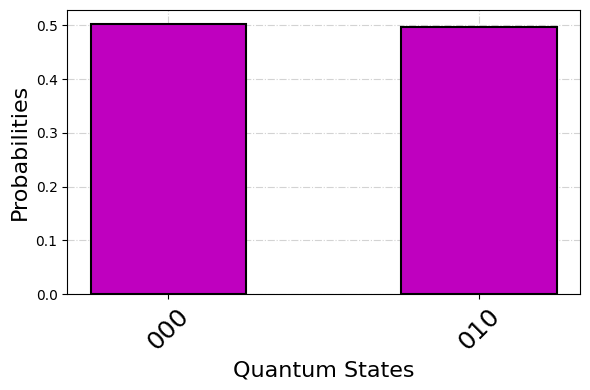

In [191]:
fig, ax = plt.subplots(1,1,dpi=100)
plt.bar(*zip(*counts.items()),color='m',width=0.5,edgecolor='k',linewidth=1.5)
x_ticks_labels = counts.keys()
ax.set_xticklabels(x_ticks_labels, rotation=45, fontsize=18)
ax.set_xlabel("Quantum States",fontsize=16)
ax.set_ylabel("Probabilities",fontsize=16)
ax.set_axisbelow(True)
ax.grid(linestyle='-.',color='lightgray',zorder=0)
fig.tight_layout()

# **Verifying Our Simple Python Simulator using Qiskit**

In this section, we first import Qiskit and then using the same circuit(s), get the final probabilities and compare it with our simulator results. Hopefully they match? 


## Entangled State Simulation Test

In this section, we try to create an entangled state with Qiskit and our simulator and observe if the results are similar or not.

In [192]:
from qiskit import QuantumCircuit
from numpy import pi
from qiskit import execute, Aer
from qiskit.visualization import plot_histogram
backend = Aer.get_backend("statevector_simulator")

In [193]:
# Qiskit
circuit = QuantumCircuit(2)
# circuit.u3(params[0], params[1], params[2], 0)
circuit.h(0)
circuit.cx(0,1)
# circuit.draw(output='mpl')
job = execute(circuit,backend=backend)
statevector = job.result().get_statevector()
qiskit_results = execute(circuit,backend).result().get_counts()

In [194]:
# Our simulator
circuit = quantum_circuit(2)
our_circuit = [
{ "gate": "h", "target": [0] },
{"gate": "cx", "target" : [0,1]}]
my_qpu = circuit.get_ground_state()
final_state = circuit.run_program(my_qpu,our_circuit)
num_shots=10000
our_results = circuit.get_counts(final_state, num_shots)

C:\Users\neeln\anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


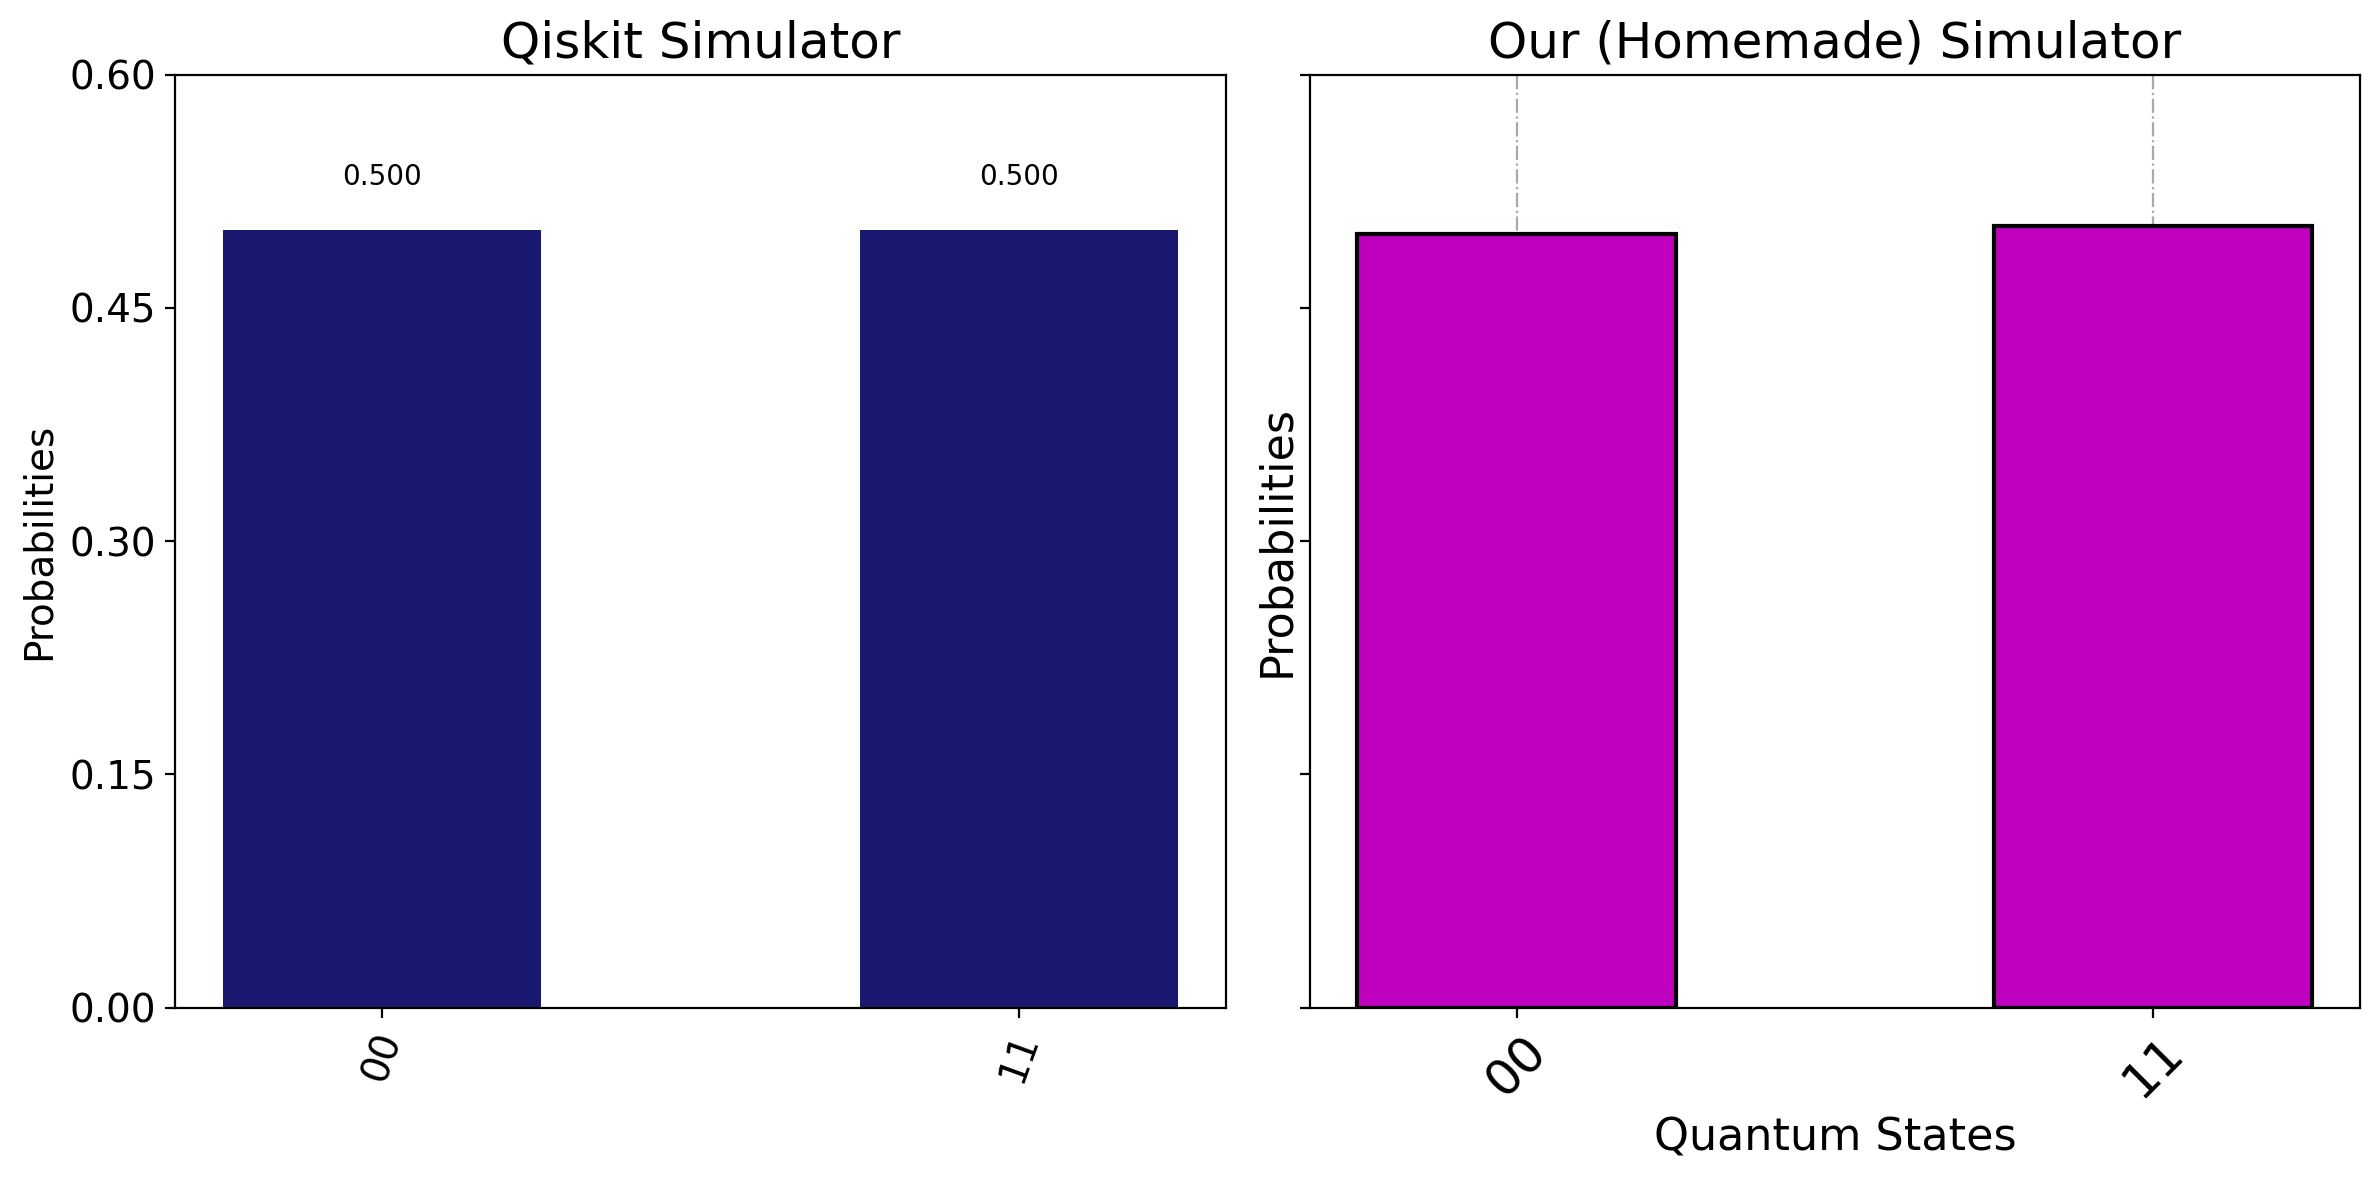

In [195]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6),sharey='row',dpi=200)
plot_histogram(qiskit_results, color='midnightblue',ax=ax1)
ax1.set_title("Qiskit Simulator", fontsize=18)

ax2.bar(*zip(*our_results.items()),color='m',width=0.5,edgecolor='k',linewidth=1.5)
x_ticks_labels = our_results.keys()
ax2.set_xticklabels(x_ticks_labels, rotation=45, fontsize=18)
ax2.set_xlabel("Quantum States",fontsize=16)
ax2.set_ylabel("Probabilities",fontsize=16)
ax2.set_axisbelow(True)
ax2.grid(linestyle='-.',color='darkgray',zorder=0)
ax2.set_title("Our (Homemade) Simulator", fontsize=18)
fig.tight_layout()

## U3 Parametric Gate + Some Other Gates

In this section, we try the U3 parametric gate from Qiskit and the same gates from our simulator to see what we get. 

In [196]:
# Defining parameters for the parameterized gate

_theta = 3.9415; _phi= 1.5708; _lambda= -3.1415;
params = [_theta, _phi, _lambda]

In [206]:
# Qiskit
circuit = QuantumCircuit(10)
circuit.u3(params[0], params[1], params[2], 0)
circuit.h(1)
circuit.cx(0,2)
# circuit.reverse_bits()
circuit.draw(output='mpl')
job = execute(circuit,backend=backend)
statevector = job.result().get_statevector()
qiskit_results = execute(circuit.reverse_bits(),backend).result().get_counts()

In [207]:
# Our simulator
circuit = quantum_circuit(10)
our_circuit = [
{ "gate": "U3", "params": { "theta": params[0], "phi": params[1], "lambda": params[2] }, "target": [0] },
{ "gate": "h", "target": [1] },
{"gate": "cx", "target" : [0,2]}]
my_qpu = circuit.get_ground_state()
final_state = circuit.run_program(my_qpu,our_circuit)
num_shots=10000
our_results = circuit.get_counts(final_state, num_shots)

C:\Users\neeln\anaconda3\envs\quantum\lib\site-packages\ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


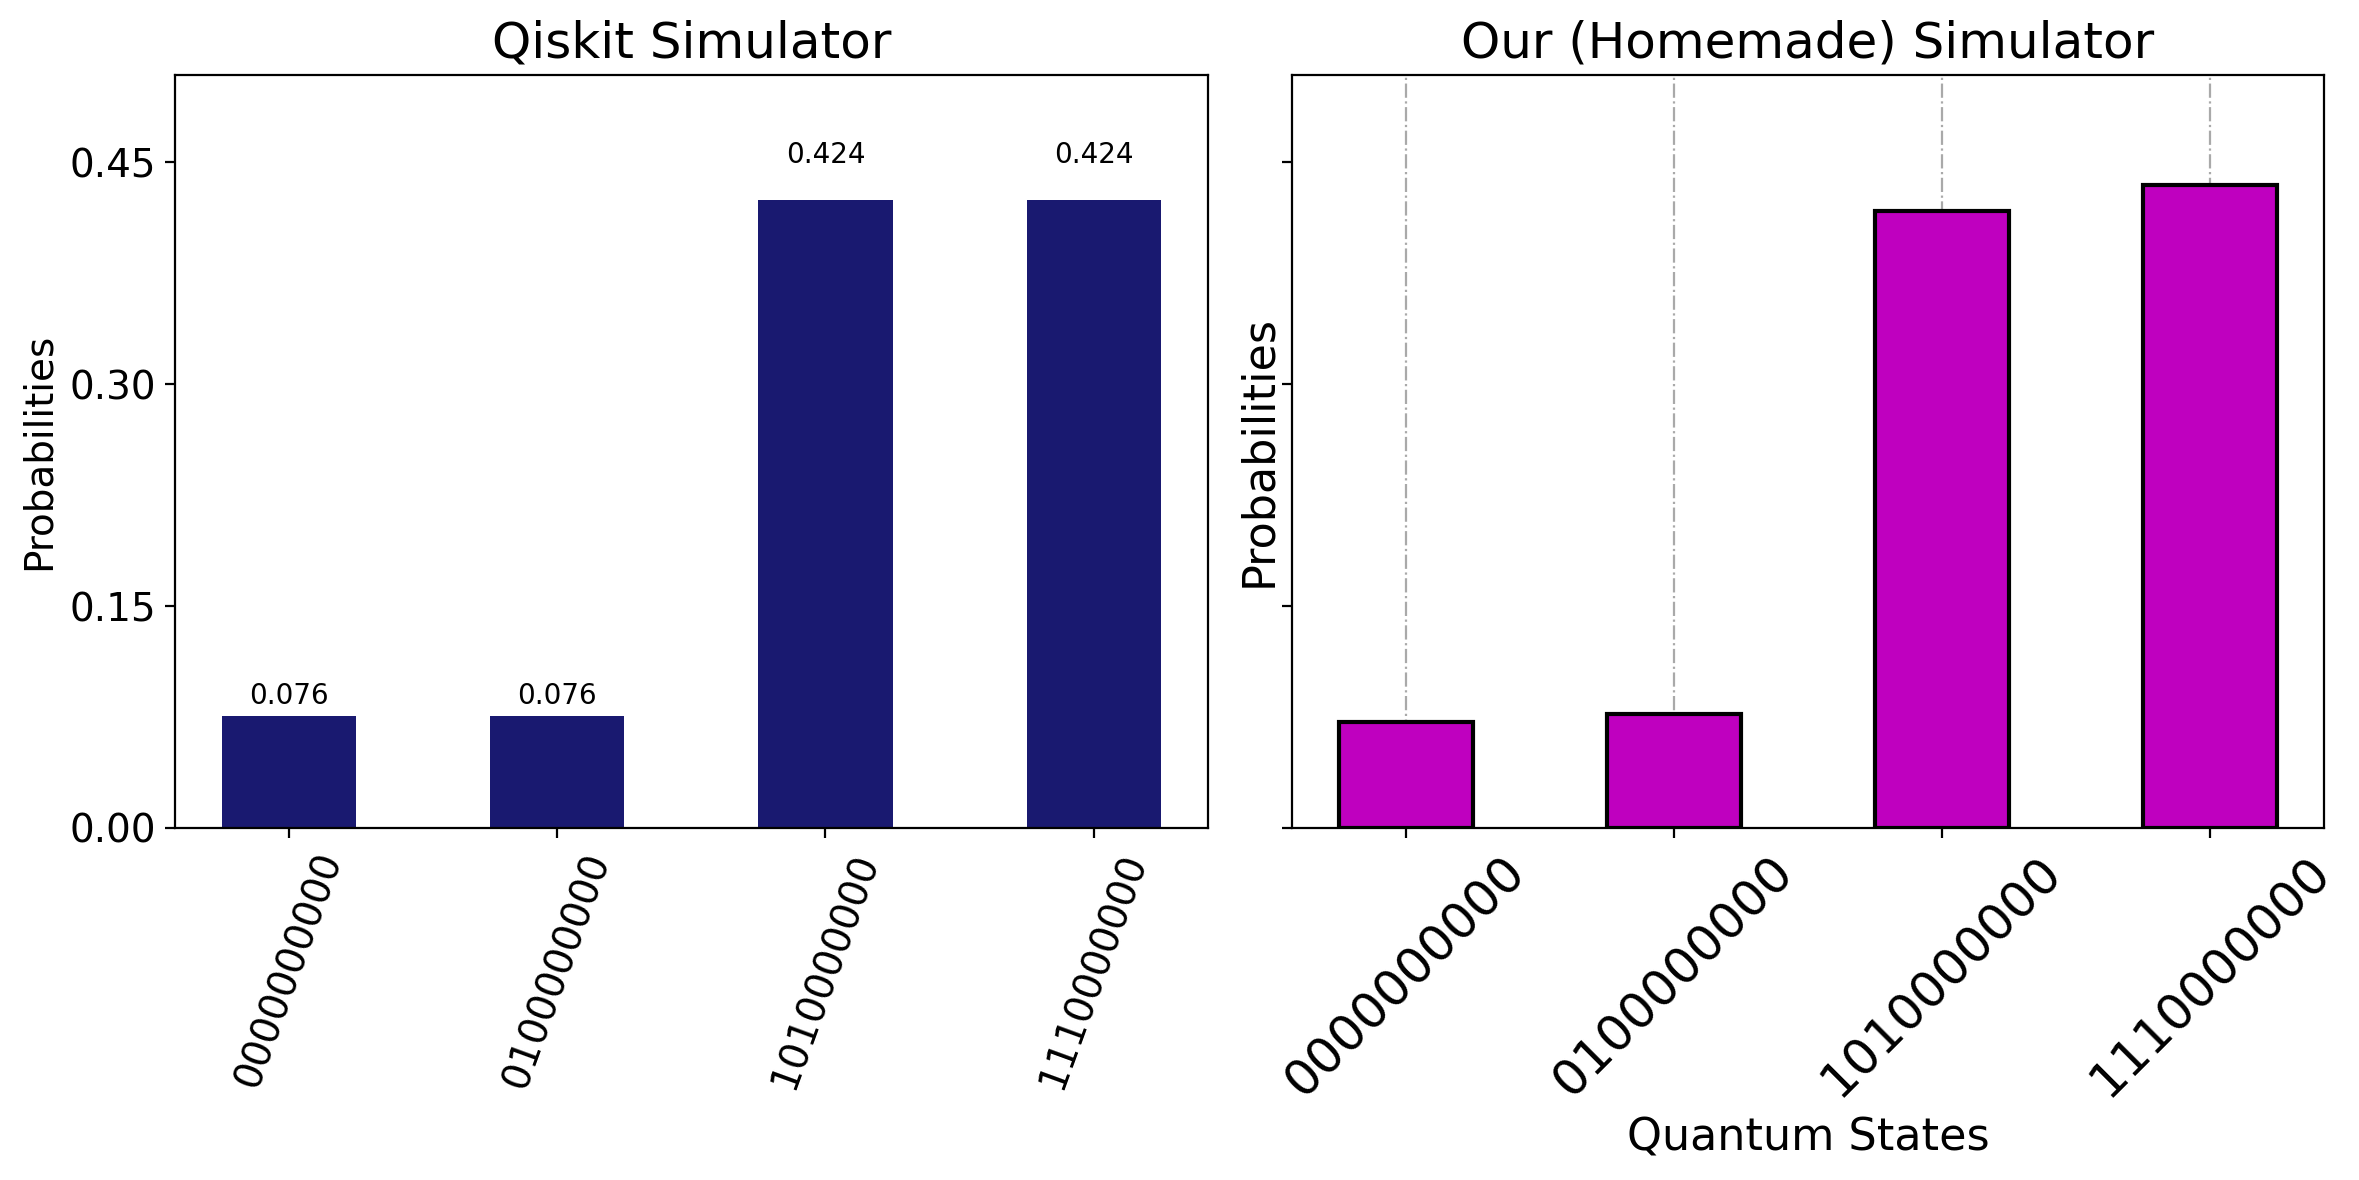

In [208]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,6),sharey='row',dpi=200)
plot_histogram(qiskit_results, color='midnightblue',ax=ax1)
ax1.set_title("Qiskit Simulator", fontsize=18)

ax2.bar(*zip(*our_results.items()),color='m',width=0.5,edgecolor='k',linewidth=1.5)
x_ticks_labels = our_results.keys()
ax2.set_xticklabels(x_ticks_labels, rotation=45, fontsize=18)
ax2.set_xlabel("Quantum States",fontsize=16)
ax2.set_ylabel("Probabilities",fontsize=16)
ax2.set_axisbelow(True)
ax2.grid(linestyle='-.',color='darkgray',zorder=0)
ax2.set_title("Our (Homemade) Simulator", fontsize=18)
fig.tight_layout()

## References

1. Nielsen, Michael A., and Isaac Chuang. "Quantum computation and quantum information." (2002): 558-559.
2. https://github.com/quantastica/qosf-mentorship/blob/master/qosf-simulator-task.ipynb

Created by Neel Chatterjee